In [1]:
import os
import numpy as np
import scipy.linalg as spl
import matplotlib.pyplot as plt
from time import perf_counter
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from itertools import count
from tqdm import trange
from utils import *
from parameter_vae import VAE as y_VAE
from state_vae import VAE as h_VAE

In [2]:
dtype = torch.float32
if torch.cuda.is_available():
    gpus = [f"cuda:{i}" for i in range(torch.cuda.device_count())]
print(f"Available GPUs: {gpus}")
torch.set_default_dtype(dtype)
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f'using device:{device}')

rand_seed = 42
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

Available GPUs: ['cuda:0', 'cuda:1']
using device:cuda:1


In [3]:
def reparameterize(mean, logvar):
    eps = np.random.randn(mean.shape)
    return eps * np.exp(0.5 * logvar) + mean

In [4]:
# Load data
with h5py.File('./freyberg_tv_data_5000_f32_all.h5', 'r') as f:
    #print([key for key in f.keys()])
    y_ref = f.get('y_ref')[:]  #(40, 20)
    h_ref = f.get('h_ref')[:-1, ...] #(24, 40, 20)
    y_data = f.get('y_data')[:] #(5000, 40, 20)
    h_data = f.get('h_data')[:, :-1, ...]  #(5000, 24, 40, 20)
    coord_data = f.get('coord_data')[:] 

# Note that the K data follows log-normal distribution with very long tails (heavily right-skewed)
# The min is around 0 and the max is upto 200

In [ ]:
# Domain geometry & model setup
Nx = 20
Ny = 40
Nt = 24
Ncells_raw = Nx * Ny
Ncells = 706
Ntrain = 4950
Ntest = 50
y_latent_dim = 150
h_latent_dim = 90
hidden_size = 2000
num_epoch = 1000
num_print = 10
batch_size = 64
gamma = 1e-4
lr = 1e-4

current_directory = os.getcwd()
path_f   = os.path.join(current_directory , f'VAE_DNN_Freyberg')
if not os.path.exists(path_f):
    os.makedirs(path_f)
f_rec = open(os.path.join(path_f, 'record.out'), 'a+')

save_results_to = os.path.join(path_f  , "results/")
if not os.path.exists(save_results_to):
    os.makedirs(save_results_to)
    
save_fig_to = os.path.join(path_f  , "figure/")
if not os.path.exists(save_fig_to):
    os.makedirs(save_fig_to)

checkpoint_dir = save_results_to + 'checkpoints/'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


We begin by pre‐processing the data. A mask is first generated to exclude any NaN entries. Using only the valid (active) cell values in the training data, we extract the maximum $y_{\max}$ and minimum $y_{\min}$ values. Then, a min--max normalization is applied to rescale the data into the interval $[-1,1]$, i.e.,
$$
\tilde{y} = \frac{2\,(y - y_{\min})}{y_{\max} - y_{\min}} - 1.
$$
Any remaining NaN values are replaced by $-1$, and the normalized data are converted into PyTorch tensors. The same process applys to hydraulic head $h$ data.

The $y$ tensor is then passed through an pretrained encoder network from $y$ VAE. This encoder outputs the mean $\mu$ and the logarithm of the variance $\log\sigma^2$ of the latent variables. In other words, the encoder maps the input $y$ to a probabilistic latent representation $(\mu_y, \log\sigma_y^2)$. Subsequently, a decoder network is used to reconstruct the target (here, the PDE state $h$). The latent representation is first reparameterized (using the reparameterization trick) and then passed through the decoder, which produces a reconstructed output. 

In [6]:
# Pre-processing data
mask = ~(np.isnan(y_ref)) #(Ny, Nx)
mask_rep_batch = lambda x: np.tile(mask, (x.shape[0], 1, 1)) # return (Nbatch, Ny, Nx)
mask_t = np.tile(mask, (Nt, 1, 1)) #(Nt, Ny, Nx)
mask_t_rep_batch = lambda x: np.tile(mask_t, (x.shape[0], 1, 1, 1)) # return (Nbatch, Nt, Ny, Nx)

y_train = y_data[:Ntrain, :, :] 
y_test = y_data[Ntrain:, :, :]  
y_train_max = y_train[mask_rep_batch(y_train)].max()
y_train_min = y_train[mask_rep_batch(y_train)].min()
y_train_norm = normalize(y_train, y_train_max, y_train_min)
y_test_norm = normalize(y_test, y_train_max, y_train_min)
y_ref_norm  = normalize(y_ref, y_train_max, y_train_min)
y_train_norm = np.nan_to_num(y_train_norm, False, -1) 
y_test_norm = np.nan_to_num(y_test_norm, False, -1) 
y_ref_norm = np.nan_to_num(y_ref_norm, False, -1) 

y_train_torch = torch.tensor(y_train_norm[:, np.newaxis, ...], 
                             dtype = dtype).to(device) 
y_test_torch = torch.tensor(y_test_norm[:, np.newaxis, ...], 
                            dtype = dtype).to(device)
y_ref_torch = torch.tensor(y_ref_norm[np.newaxis, np.newaxis, ...], 
                           dtype=dtype).to(device)

h_train = h_data[:Ntrain, :, :] 
h_test = h_data[Ntrain:, :, :] 
h_train_max = h_train[mask_t_rep_batch(h_train)].max()
h_train_min = h_train[mask_t_rep_batch(h_train)].min()
h_train_norm = normalize(h_train, h_train_max, h_train_min)
h_test_norm = normalize(h_test, h_train_max, h_train_min)
h_ref_norm  = normalize(h_ref, h_train_max, h_train_min)
h_train_norm = np.nan_to_num(h_train_norm, False, -1) 
h_test_norm = np.nan_to_num(h_test_norm, False, -1) 
h_ref_norm = np.nan_to_num(h_ref_norm, False, -1) 

h_train_torch = torch.tensor(h_train_norm[:, np.newaxis, ...], 
                             dtype = dtype).to(device) # (Nbatch, Nchannel, Nt, Ny, Nx)
h_test_torch = torch.tensor(h_test_norm[:, np.newaxis, ...], 
                            dtype = dtype).to(device)
h_ref_torch = torch.tensor(h_ref_norm[np.newaxis, np.newaxis, ...], 
                           dtype=dtype).to(device)

y_vae = y_VAE(Ny, Nx, Nchannel = 1, latent_dim = y_latent_dim, gamma = gamma, 
            lr = lr, mask = mask, device = device, dtype = dtype)
h_vae = h_VAE(Ny, Nx, Nt, Nchannel = 1, latent_dim = h_latent_dim, gamma = gamma,
               lr = lr, mask_t = mask_t, device = device, dtype = dtype)
y_encoder_weights_path = os.path.join(path_f, 'y_encoder_weights.pth')
y_decoder_weights_path = os.path.join(path_f, 'y_decoder_weights.pth')
h_encoder_weights_path = os.path.join(path_f, 'h_encoder_weights.pth')
h_decoder_weights_path = os.path.join(path_f, 'h_decoder_weights.pth')
y_vae.encoder.load_state_dict(torch.load(y_encoder_weights_path, map_location=device))
y_vae.decoder.load_state_dict(torch.load(y_decoder_weights_path, map_location=device))
h_vae.encoder.load_state_dict(torch.load(h_encoder_weights_path, map_location=device))
h_vae.decoder.load_state_dict(torch.load(h_decoder_weights_path, map_location=device))

mean_xiY_train, logvar_xiY_train = y_vae.encoder(y_train_torch)
mean_xiY_test, logvar_xiY_test = y_vae.encoder(y_test_torch)
mean_xiY_ref, logvar_xiY_ref = y_vae.encoder(y_ref_torch)

mean_etah_train, logvar_etah_train = h_vae.encoder(h_train_torch)
mean_etah_test, logvar_etah_test = h_vae.encoder(h_test_torch)
mean_etah_ref, logvar_etah_ref = h_vae.encoder(h_ref_torch)


/tmp/ipykernel_3836238/2718482753.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  y_vae.encoder.load_state_dict(torch.load(y_encoder_weights_path, map_location=device))

In [ ]:
mean_xiY_train = mean_xiY_train.detach().cpu().numpy()
logvar_xiY_train = logvar_xiY_train.detach().cpu().numpy()
mean_xiY_test = mean_xiY_test.detach().cpu().numpy()
logvar_xiY_test = logvar_xiY_test.detach().cpu().numpy()
mean_xiY_ref = mean_xiY_ref.detach().cpu().numpy()
logvar_xiY_ref = logvar_xiY_ref.detach().cpu().numpy()

mean_xiY_train_max = np.max(mean_xiY_train)
mean_xiY_train_min = np.min(mean_xiY_train)
mean_xiY_train = normalize(mean_xiY_train, mean_xiY_train_max, mean_xiY_train_min)
mean_xiY_test = normalize(mean_xiY_test, mean_xiY_train_max, mean_xiY_train_min)
mean_xiY_ref  = normalize(mean_xiY_ref, mean_xiY_train_max, mean_xiY_train_min)

mean_xiY_train = torch.tensor(mean_xiY_train, dtype = dtype).to(device) 
mean_xiY_test = torch.tensor(mean_xiY_test, dtype = dtype).to(device) 
mean_xiY_ref = torch.tensor(mean_xiY_ref, dtype = dtype).to(device) 
# logvar_xiY_train = torch.tensor(logvar_xiY_train, dtype=dtype).to(device)
# logvar_xiY_test = torch.tensor(logvar_xiY_test, dtype=dtype).to(device)
# logvar_xiY_ref = torch.tensor(logvar_xiY_ref, dtype=dtype).to(device)

mean_etah_train = mean_etah_train.detach().cpu().numpy()
logvar_etah_train = logvar_etah_train.detach().cpu().numpy()
mean_etah_test = mean_etah_test.detach().cpu().numpy()
logvar_etah_test = logvar_etah_test.detach().cpu().numpy()
mean_etah_ref = mean_etah_ref.detach().cpu().numpy()
logvar_etah_ref = logvar_etah_ref.detach().cpu().numpy()

# mean_etah_train_max = np.max(mean_etah_train)
# mean_etah_train_min = np.min(mean_etah_train)
# mean_etah_train = normalize(mean_etah_train, mean_etah_train_max, mean_etah_train_min)
# mean_etah_test = normalize(mean_etah_test, mean_etah_train_max, mean_etah_train_min)
# mean_etah_ref  = normalize(mean_etah_ref, mean_etah_train_max, mean_etah_train_min)

mean_etah_train = torch.tensor(mean_etah_train, dtype = dtype).to(device) 
mean_etah_test = torch.tensor(mean_etah_test, dtype = dtype).to(device) 
mean_etah_ref = torch.tensor(mean_etah_ref, dtype = dtype).to(device) 
# logvar_etah_train = torch.tensor(logvar_etah_train, dtype=dtype).to(device)
# logvar_etah_test = torch.tensor(logvar_etah_test, dtype=dtype).to(device)
# logvar_etah_ref = torch.tensor(logvar_etah_ref, dtype=dtype).to(device)

print('\n')
print('xiY training data shape: {}'.format(mean_xiY_train.shape))
print('xiY test data shape: {}'.format(mean_xiY_test.shape))
print('etah training data shape: {}'.format(mean_etah_train.shape))
print('etah test data shape: {}'.format(mean_etah_test.shape))



xiY training data shape: torch.Size([4950, 150])
xiY test data shape: torch.Size([50, 150])
etah training data shape: torch.Size([4950, 90])
etah test data shape: torch.Size([50, 90])


In [ ]:
class LatentNet(nn.Module):

    def __init__(self, input_dim, output_dim, hidden_size, gamma, device, rand_seed=42):

        super(LatentNet, self).__init__()

        self.gamma = gamma
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_size = hidden_size
        self.device = device
        self.rand_seed = rand_seed
        
        self.latent_net = nn.Sequential(
            nn.Linear(input_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, output_dim)
        )
        
        # torch.manual_seed(rand_seed)
        # for layer in self.latent_net:
        #     if isinstance(layer, nn.Linear):
        #         nn.init.xavier_normal_(layer.weight, gain=nn.init.calculate_gain('tanh'))
        #         if layer.bias is not None:
        #             nn.init.zeros_(layer.bias)
        self.to(device)

    def forward(self, x):
        return self.latent_net(x)
    
    # def compute_loss(self, x, y):

    #     # Forward pass
    #     output = self.forward(x)
    #     latent_dim = output.shape[1] // 2
        
    #     # Split output and target into mean and log-variance parts
    #     mean_z_pred = output[:, :latent_dim]
    #     logvar_z_pred = output[:, latent_dim:]
    #     mean_z_true = y[:, :latent_dim]
    #     logvar_z_true = y[:, latent_dim:]
        
    #     loss_mean = torch.mean((mean_z_pred - mean_z_true) ** 2)
    #     loss_logvar = torch.mean((logvar_z_pred - logvar_z_true) ** 2)
    #     loss_value = loss_mean + self.gamma * loss_logvar
    #     return loss_value

    def l2_loss(self, pred_mu, target_mu):
        return torch.mean((pred_mu - target_mu) ** 2)

    def kl_divergence_loss(self, pred_mu, pred_logvar, target_mu, target_logvar):

        pred_var = torch.exp(pred_logvar)  
        target_var = torch.exp(target_logvar)
        term1 = torch.log(target_var / pred_var)  # log |Σ_phi_h| / |Σ'_phi_h|
        term2 = (target_mu - pred_mu)**2 / pred_var  # (μ_phi_h - μ'_phi_h)^T Σ'_phi_h^{-1} (μ_phi_h - μ'_phi_h)
        term3 = target_var / pred_var  # tr(Σ'_phi_h^{-1} Σ_phi_h)
        kl_loss = torch.mean(term1 + term2 + term3) 
        return kl_loss 

    def train_model(self, train_data, test_data, batch_size, num_epoch, num_print):

        x_train, y_train = train_data
        x_test, y_test = test_data

        if not torch.is_tensor(x_train):
            x_train = torch.tensor(x_train, dtype=torch.float32).to(self.device)
        if not torch.is_tensor(y_train):
            y_train = torch.tensor(y_train, dtype=torch.float32).to(self.device)
        if not torch.is_tensor(x_test):
            x_test = torch.tensor(x_test, dtype=torch.float32).to(self.device)
        if not torch.is_tensor(y_test):
            y_test = torch.tensor(y_test, dtype=torch.float32).to(self.device)
        
        optimizer = optim.Adam(self.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-07, weight_decay=gamma)
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
         
        train_dataset = TensorDataset(x_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        
        train_loss_log = []
        test_loss_log = []
        pbar = trange(num_epoch)
        for epoch in pbar:
            
            self.train()  
            train_loss_epoch = 0.0

            for batch_x, batch_y in train_loader:
                optimizer.zero_grad()
                batch_y_pred = self.forward(batch_x)
                loss_batch = nn.MSELoss()(batch_y_pred, batch_y)
                loss_batch.backward()
                optimizer.step()
                train_loss_epoch += loss_batch.item()

            num_batches = len(train_loader)
            train_loss_epoch /= num_batches
            
            if epoch % num_print == 0:
                self.eval()
                with torch.no_grad():
                    y_test_pred = self.forward(x_test)
                    test_loss = nn.MSELoss()(y_test_pred, y_test).item()
                train_loss_log.append(train_loss_epoch)
                test_loss_log.append(test_loss)
                pbar.set_postfix({'Train Loss': train_loss_epoch, 'Test Loss': test_loss})
            
            #scheduler.step() # Update the learning rate scheduler after each epoch
        
        return np.array(train_loss_log), np.array(test_loss_log)

100%|██████████| 5000/5000 [23:29<00:00,  3.55it/s, Train Loss=0.00305, Test Loss=0.00414]


Total trainable parameters: 18729090
Convolutional VAE Training Time 1409.234


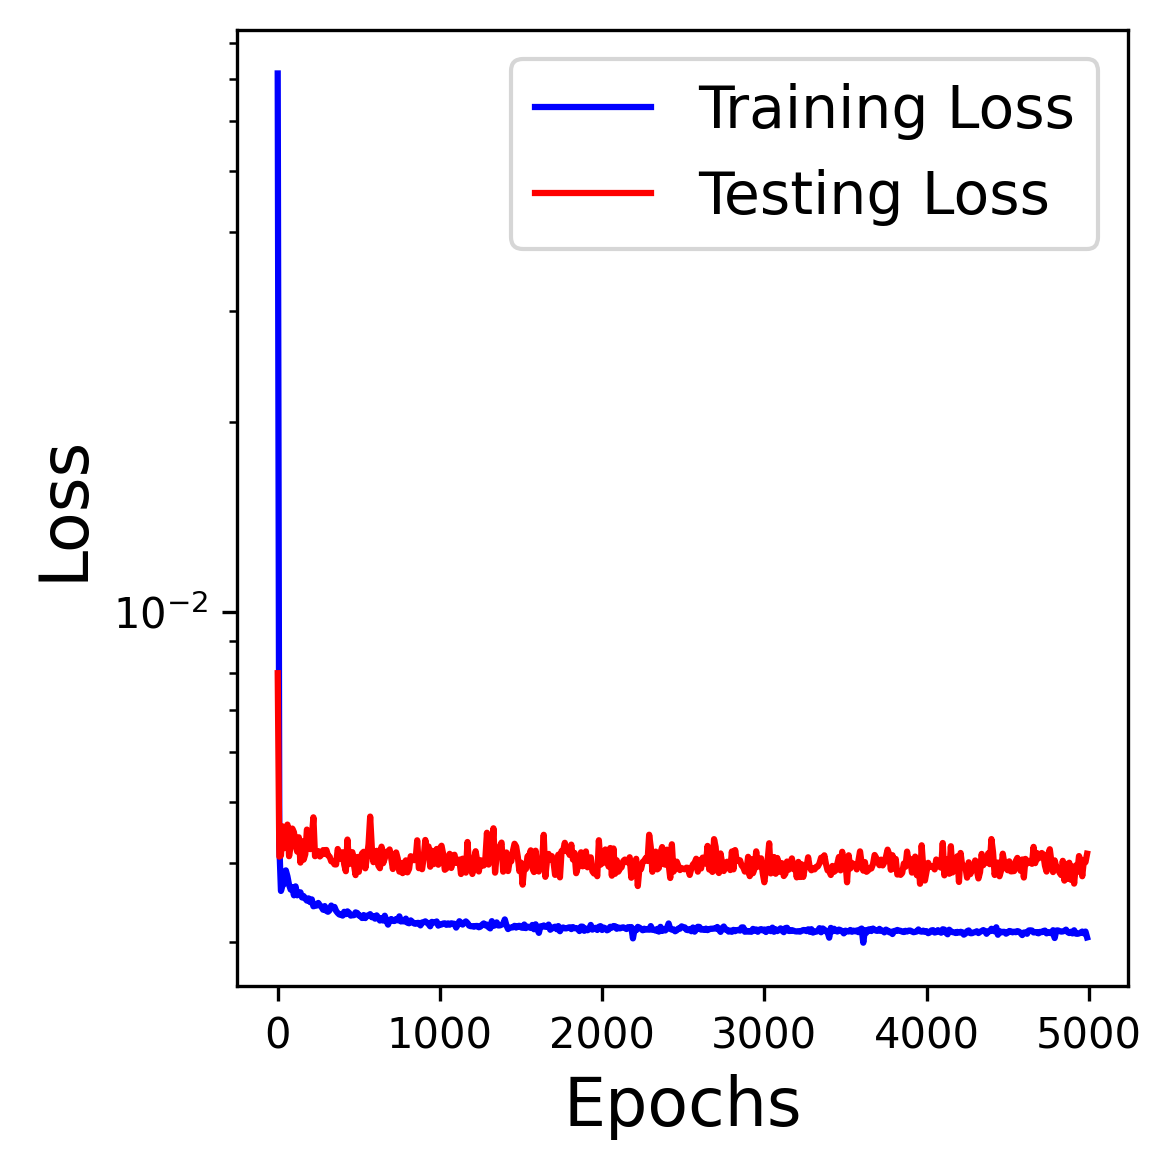

In [9]:
model = LatentNet(y_latent_dim, h_latent_dim, hidden_size, gamma, device, rand_seed=42)
ts = perf_counter()
train_loss, test_loss = model.train_model(
                                    train_data= (mean_xiY_train, mean_etah_train),
                                    test_data= (mean_xiY_test, mean_etah_test),
                                    batch_size = batch_size,
                                    num_epoch= num_epoch,
                                    num_print = num_print,
                                    )
elps_time = perf_counter() - ts
torch.save(model.state_dict(), os.path.join(path_f, 'latent_net_weights.pth'))

total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_trainable_params}")
print(f'input_dim: {y_latent_dim} \t output_dim:{h_latent_dim}' , file = f_rec)
print(f'hidden size: {hidden_size} \t epochs:{num_epoch} \t gamma:{gamma} \t lr:{lr}', file = f_rec)
print(f'number of trainables:{total_trainable_params}', file = f_rec)
print(f'Convolutional VAE Training Time {elps_time:.3f}')
print(f'Convolutional VAE Training Time {elps_time:.3f}', file = f_rec)
plot_loss(train_loss, test_loss, num_epoch, num_print, save_fig_to)

Relative L2 error of href: 3.13e-03


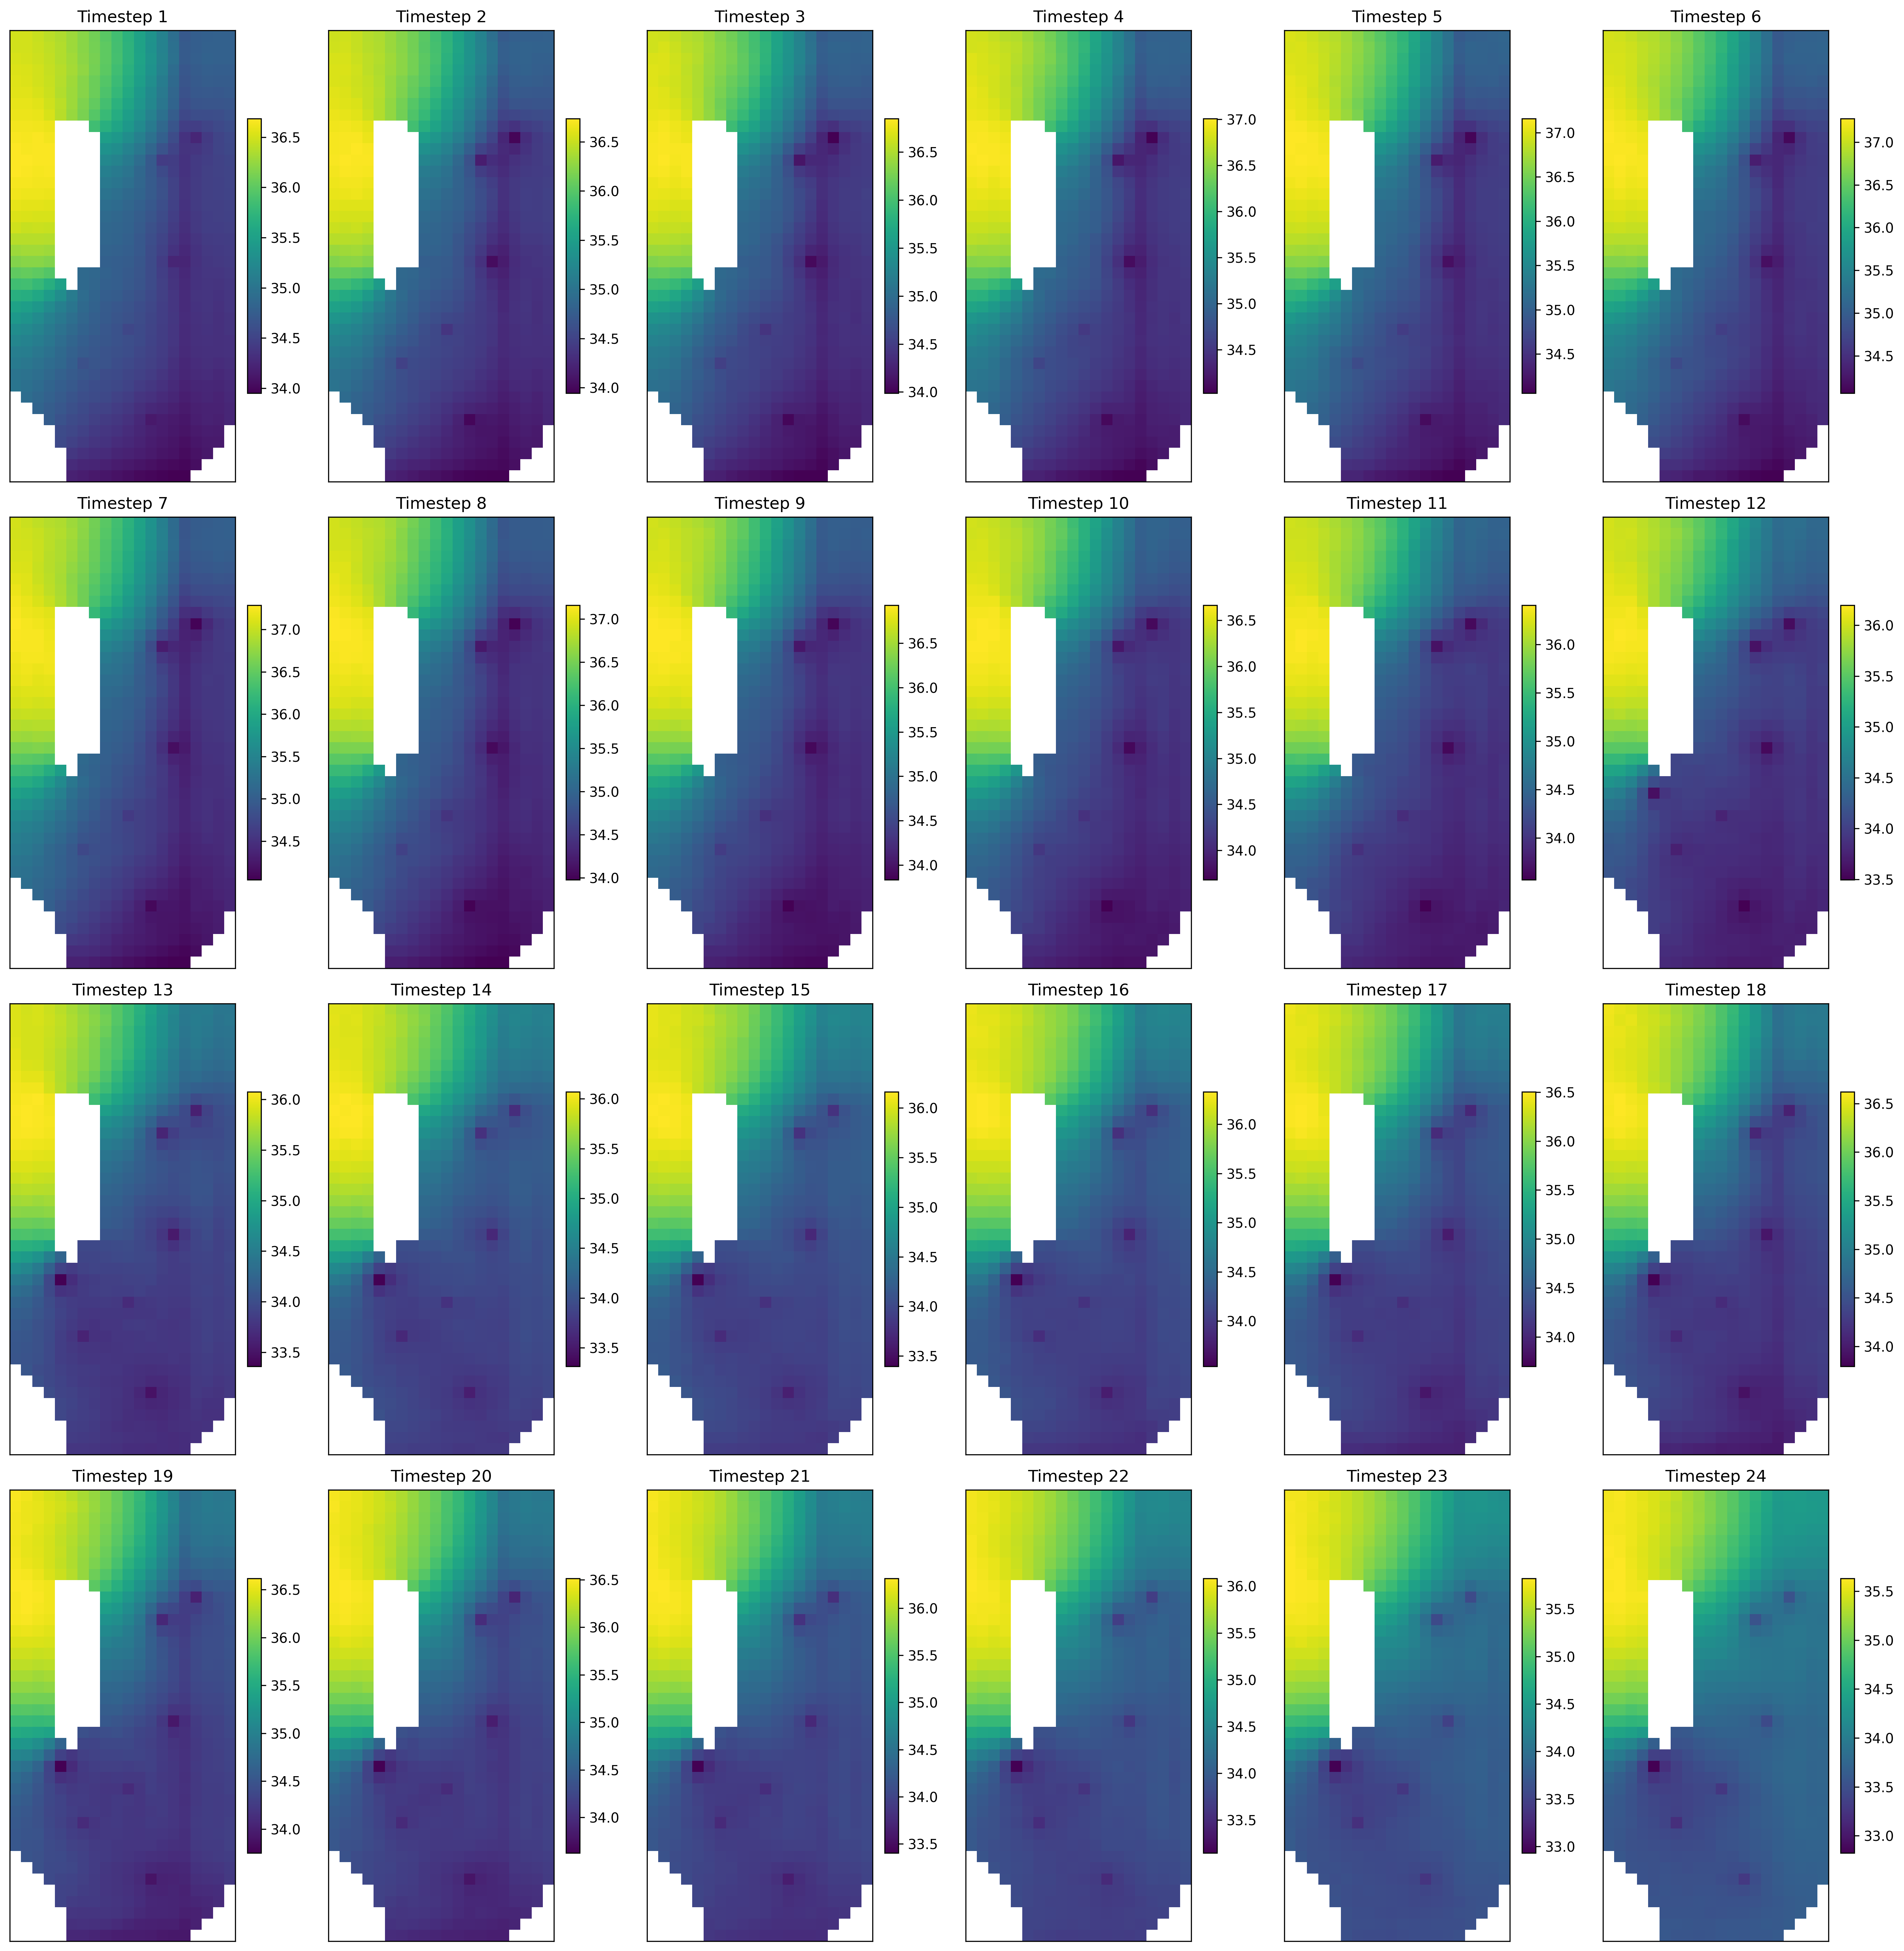

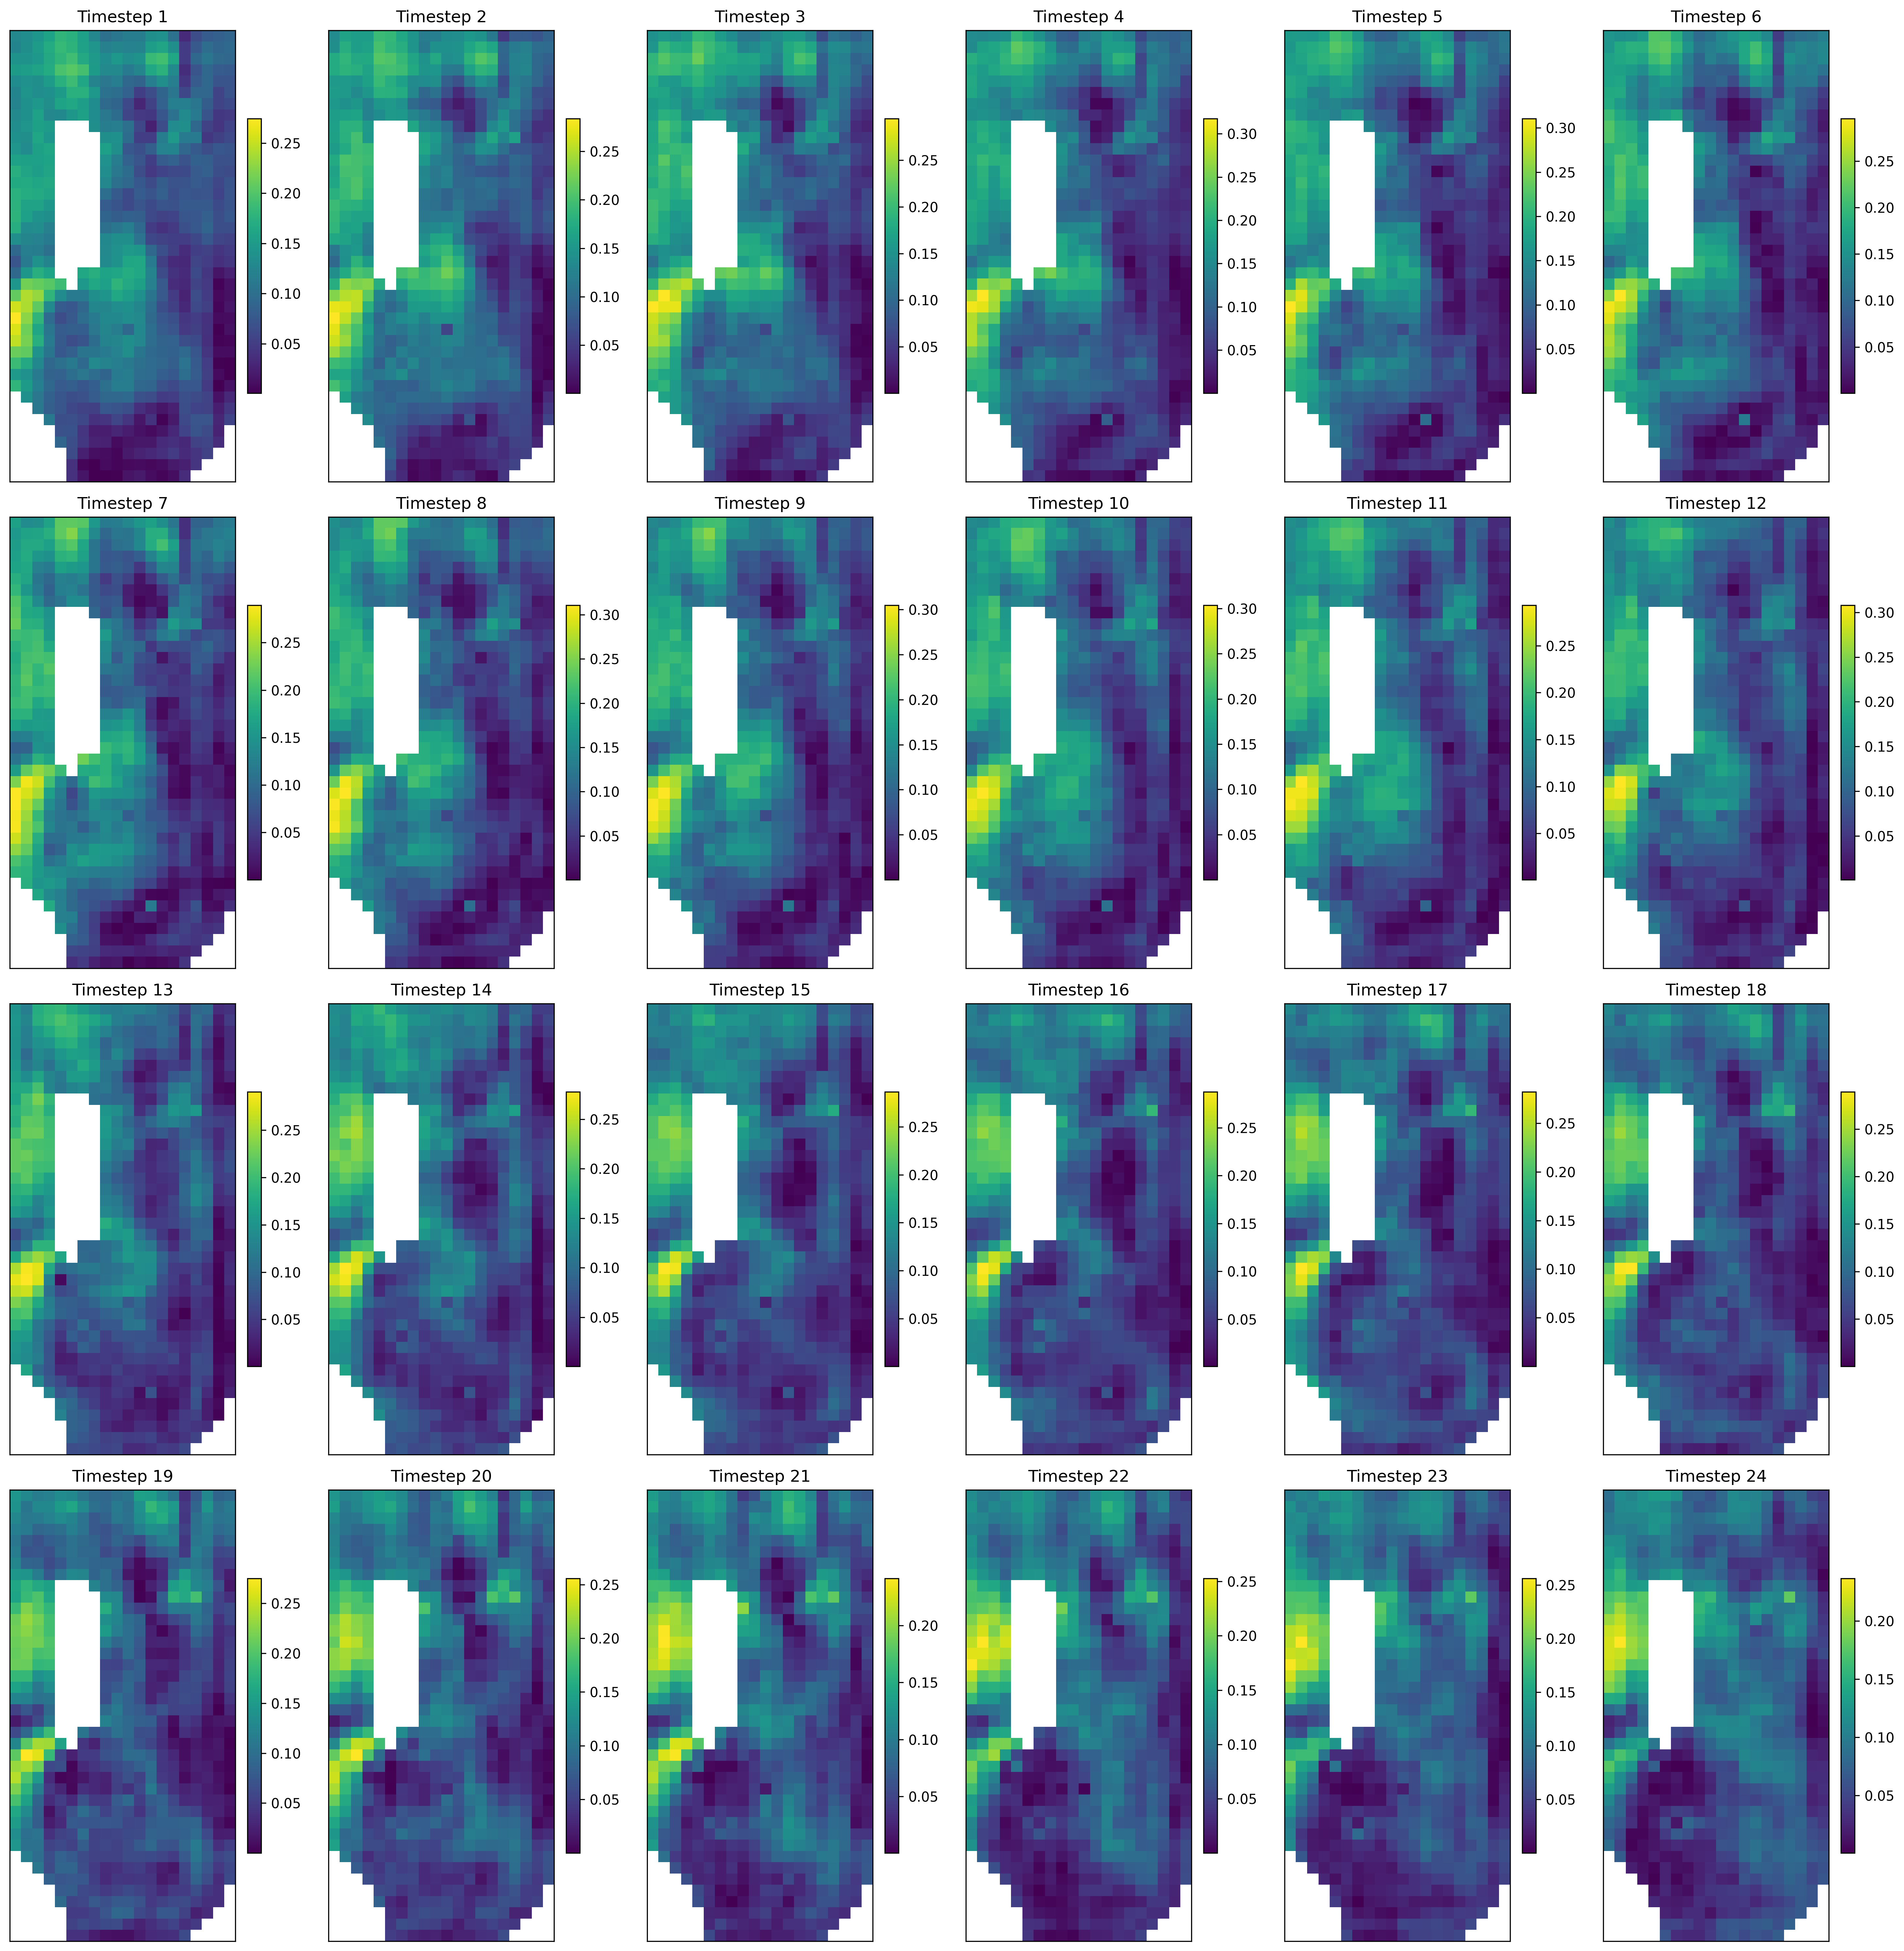

In [10]:
########### post-analysis #############
mean_etah_ref_pred = model(mean_xiY_ref)
#mean_etah_ref_pred = back_normalize(mean_etah_ref_pred, mean_etah_train_max, mean_etah_train_min)
h_recon = h_vae.decoder(mean_etah_ref_pred).detach().cpu().numpy()[0, 0, ...]
h_recon = back_normalize(h_recon, h_train_max, h_train_min)
h_recon_masked = h_recon[mask_t]
h_ref_masked = h_ref[mask_t]
rl2_error = rl2e(h_recon_masked, h_ref_masked)
print('Relative L2 error of href: {:.2e}'.format(rl2_error))
print('Relative L2 error of href: {:.2e}'.format(rl2_error), file=f_rec)
plot_field(h_recon_masked, save_fig_to + 'fig_comparison_href_all_timestep.png', mask)
plot_field(np.abs(h_recon_masked - h_ref_masked), save_fig_to + 'fig_comparison_hdiff_all_timestep.png', mask) 

In [11]:
# Visulize predictions on some training data...

# mean_z, logvar_z = model.encoder(K_train_torch[0:1, 0:1, ...])
# K_recon = model.decoder(mean_z).detach().cpu().numpy()[0, 0, ...]
# K_recon = back_normalize(K_recon, K_train_max, K_train_min)
# K_recon_masked = K_recon[mask]
# K_train_masked = back_normalize(K_train_torch, K_train_max, K_train_min)[0, 0, ...].detach().cpu().numpy()[mask]
# plot_func(mesh_recon(K_recon_masked), 
#           mesh_recon(K_train_masked), save_fig_to + 'test') 

# mean_z, logvar_z = model.encoder(y_train_torch[0:1, 0:1, ...])
# y_recon = model.decoder(mean_z).detach().cpu().numpy()[0, 0, ...]
# y_recon = back_normalize(y_recon, y_train_max, y_train_min)
# y_recon_masked = y_recon[mask]
# y_train_masked = back_normalize(y_train_torch, y_train_max, y_train_min)[0, 0, ...].detach().cpu().numpy()[mask]
# plot_func(mesh_recon(y_recon_masked), 
#           mesh_recon(y_train_masked), save_fig_to + 'test') 

In [12]:
mean_etah_test_pred = model(mean_xiY_test)
#mean_etah_test_pred = back_normalize(mean_etah_test_pred, mean_etah_train_max, mean_etah_train_min)
h_recon = h_vae.decoder(mean_etah_test_pred).detach().cpu().numpy()[:, 0, ...]
h_recon = back_normalize(h_recon, h_train_max, h_train_min)
h_recon_masked = h_recon[mask_t_rep_batch(h_test)]
h_test_masked = h_test[mask_t_rep_batch(h_test)]
rl2_error = rl2e(h_recon_masked, h_test_masked)
print('Relative L2 error of htest: {:.2e}'.format(rl2_error))
print('Relative L2 error of htest: {:.2e}'.format(rl2_error), file=f_rec)

Relative L2 error of htest: 2.59e-03
